In [1]:
import numpy as np
import pickle

import sys
sys.path.append('..')

import matplotlib.pyplot as plt

from src.utils.ICL_utils import ICLDataset, DatasetConstructor
from src.utils.model_utils import ExtendedLanguageModel
from src.utils.query_utils import get_summed_vec_per_item, compute_similarity_matrix, get_avg_summed_vec, intervene_with_vec, get_completions
from src.utils.eval_utils import SimilarityMatrix, accuracy_completions
from src.utils.globals import DATASET_DIR, RESULTS_DIR

In [2]:
datasets = [
    'antonym_eng', 
    'antonym_fr', 
    'antonym_eng-mc', 
    'categorical_eng', 
    'categorical_es', 
    'categorical_eng-mc'
]

dataset = DatasetConstructor(
    dataset_ids=datasets,
    dataset_size=20,
    batch_size=20,
    n_train=5,
    seed=100
)

In [21]:
dataset.datasets[0].print_example()

antonym_eng

Q: good
A: bad

Q: real
A: fake

Q: meaningful
A: meaningless

Q: irrelevant
A: relevant

Q: immediate
A: delayed

Q: jerk
A: gentleman

In [22]:
dataset.datasets[-1].print_example()

categorical_eng-mc

### Instruction: Q: pink A: 

(a) grain
(b) color
(c) music
(d) bird

### Response: (b)

### Instruction: Q: cobra A: 

(a) snake
(b) fish
(c) fruit
(d) dairy

### Response: (a)

### Instruction: Q: refrigerator A: 

(a) animal
(b) machine
(c) vegetation
(d) place

### Response: (b)

### Instruction: Q: frisbee A: 

(a) toy
(b) fabric
(c) gadget
(d) weapon

### Response: (a)

### Instruction: Q: mango A: 

(a) appliance
(b) toiletry
(c) ocean
(d) fruit

### Response: (d)

### Instruction: Q: albatross A: 

(a) religion
(b) bird
(c) disease
(d) science

### Response: (b

In [2]:
model = ExtendedLanguageModel('meta-llama/Meta-LLama-3.1-70B', cv_heads_n=3)

In [4]:
cvs = get_summed_vec_per_item(model=model, dataset=dataset, heads=model.cv_heads)

2025-03-04 16:39:58,500 bf7446c4-9dac-4cd5-beaf-dc2f6db49be8 - RECEIVED: Your job has been received and is waiting approval.
2025-03-04 16:39:58,771 bf7446c4-9dac-4cd5-beaf-dc2f6db49be8 - APPROVED: Your job was approved and is waiting to be run.
2025-03-04 16:39:59,218 bf7446c4-9dac-4cd5-beaf-dc2f6db49be8 - RUNNING: Your job has started running.
2025-03-04 16:40:03,517 bf7446c4-9dac-4cd5-beaf-dc2f6db49be8 - COMPLETED: Your job has been completed.


In [3]:
cvs = pickle.load(open('cvs.pkl', 'rb'))

In [4]:
cvs.shape

torch.Size([120, 8192])

In [5]:
cv_simmat = compute_similarity_matrix(cvs).numpy()
cv_simmat.shape

(120, 120)

In [15]:
simmat = SimilarityMatrix(
    sim_mat=cv_simmat,
    tasks=datasets,
    attribute_list=['antonym', 'antonym', 'antonym', 'categorical', 'categorical', 'categorical']
)

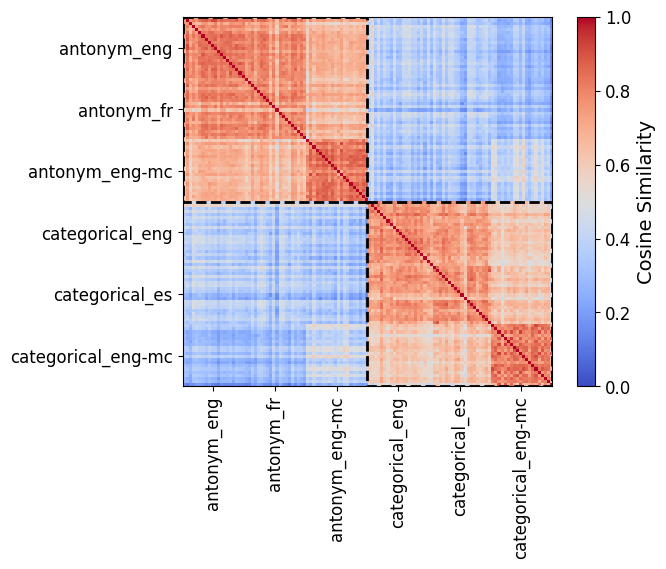

In [16]:
simmat.plot(bounding_boxes=True)

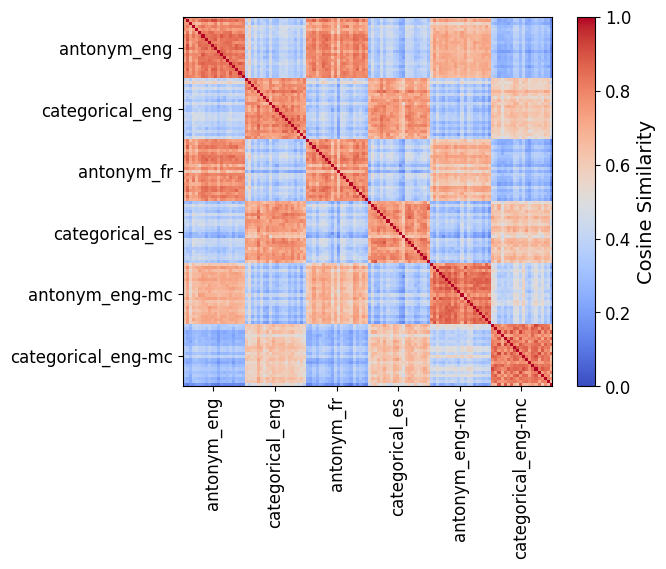

In [17]:
simmat.relocate_tasks([
    'antonym_eng', 
    'categorical_eng', 
    'antonym_fr', 
    'categorical_es', 
    'antonym_eng-mc', 
    'categorical_eng-mc'
])
simmat.plot()

# Intervention

In [14]:
dataset_intervene = ICLDataset(
    dataset=['antonym_eng', 'english_french'],
    size=100, 
    n_train=10,
    seed=42
)

In [4]:
dataset_intervene.print_example()

['antonym_eng', 'english_french']

Q: abnormal
A: normal

Q: insufficient
A: insuffisant

Q: magical
A: mundane

Q: ignore
A: ignorer

Q: most
A: least

Q: stiff
A: rigide

Q: valid
A: valide

Q: unaccustomed
A: inaccoutumé

Q: novel
A: classic

Q: formal
A: formel

Q: off
A: on

Q: practical
A: impractical

In [ ]:
dataset_extract = DatasetConstructor('antonym_fr', dataset_size=50, n_train=5, seed=42)
cv_antonym = get_avg_summed_vec(model, dataset_extract, model.cv_heads)
cv_antonym.shape

2025-03-04 17:39:30,298 442e7f7f-5d63-4245-b02d-8012052e1d8c - RECEIVED: Your job has been received and is waiting approval.
2025-03-04 17:39:32,071 442e7f7f-5d63-4245-b02d-8012052e1d8c - APPROVED: Your job was approved and is waiting to be run.
2025-03-04 17:39:33,721 442e7f7f-5d63-4245-b02d-8012052e1d8c - RUNNING: Your job has started running.
2025-03-04 17:39:36,364 442e7f7f-5d63-4245-b02d-8012052e1d8c - COMPLETED: Your job has been completed.


torch.Size([8192])

In [15]:
completions = intervene_with_vec(
    model=model, 
    dataset=dataset_intervene, 
    vector=cv_antonym*10, 
    layers=model.cv_intervention_layer
)
completions = completions[model.cv_intervention_layer] # intervene_with_vec returns a dict

2025-03-04 17:45:44,409 f9161b00-3e69-4b83-a597-18c886f3f8e7 - RECEIVED: Your job has been received and is waiting approval.
2025-03-04 17:45:45,217 f9161b00-3e69-4b83-a597-18c886f3f8e7 - APPROVED: Your job was approved and is waiting to be run.
2025-03-04 17:45:45,842 f9161b00-3e69-4b83-a597-18c886f3f8e7 - RUNNING: Your job has started running.
2025-03-04 17:45:46,150 f9161b00-3e69-4b83-a597-18c886f3f8e7 - LOG: Layer: 31
2025-03-04 17:45:51,079 f9161b00-3e69-4b83-a597-18c886f3f8e7 - COMPLETED: Your job has been completed.


In [16]:
accuracy_completions(model, completions, dataset_intervene.completions)

0.46